In [1]:
import pandas as pd


In [2]:
train_df = pd.read_csv(r".\data\train.csv")
test_df = pd.read_csv(r".\data\test.csv")

In [3]:
train_df["below_ten"] = train_df["Age"] < 10

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,below_ten
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False


In [5]:
parch_survived = train_df.groupby(
    [
        "Embarked",
    ]
)["Survived"].mean()
print(parch_survived)

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


In [6]:
sibling_survived = train_df.groupby(["SibSp", "Pclass"])["Survived"].mean()
print(sibling_survived)


SibSp  Pclass
0      1         0.562044
       2         0.416667
       3         0.236467
1      1         0.746479
       2         0.581818
       3         0.325301
2      1         0.800000
       2         0.500000
       3         0.333333
3      1         0.666667
       2         1.000000
       3         0.083333
4      3         0.166667
5      3         0.000000
8      3         0.000000
Name: Survived, dtype: float64


In [7]:
gender_pclass_below_ten = train_df.groupby(["Pclass", "Sex", "below_ten"])[
    "Survived"
].mean()
if type(gender_pclass_below_ten) is not pd.Series:
    raise Exception("gender_pclass_below_ten is not a Series")
gender_pclass_below_ten[(1, "female", True)] = 1
print(gender_pclass_below_ten)

Pclass  Sex     below_ten
1       female  False        0.978495
                True         1.000000
        male    False        0.358333
                True         1.000000
2       female  False        0.911765
                True         1.000000
        male    False        0.080808
                True         1.000000
3       female  False        0.495935
                True         0.523810
        male    False        0.119632
                True         0.380952
Name: Survived, dtype: float64


In [8]:
# predict test_df using gender_pclass_below_ten
# Add the below_ten feature to test_df, consistent with train_df
test_df["below_ten"] = test_df["Age"] < 10

# Prepare an output DataFrame with predictions
predictions = []

# For each row in test_df, lookup the gender_pclass_below_ten prediction.
# If not found, fallback to a simpler mean if necessary
for idx, row in test_df.iterrows():
    key = (row["Pclass"], row["Sex"], row["below_ten"])
    pred = gender_pclass_below_ten[key]
    # Convert predicted mean back to binary classification (threshold 0.5)
    predictions.append(int(pred >= 0.5))

# Store predictions with PassengerId
submission = pd.DataFrame(
    {"PassengerId": test_df["PassengerId"], "Survived": predictions}
)

submission.to_csv("submission.csv", index=False)


In [9]:
survived_counts = train_df["Survived"].value_counts()

print(
    f"Total passengers: {survived_counts.sum()}, Survived: {survived_counts[1]}, Died: {survived_counts[0]}"
)

Total passengers: 891, Survived: 342, Died: 549


In [10]:
pclass_counts = train_df["Pclass"].value_counts()
pclass_survived = train_df.groupby("Pclass")["Survived"].mean()
print(pclass_counts, pclass_survived)

Pclass
3    491
1    216
2    184
Name: count, dtype: int64 Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


In [11]:
gender_pclass = train_df.groupby(["Pclass", "Sex"])["Survived"].mean()
print(gender_pclass)

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64


In [12]:
bucket_size = 5
age_by_tens_survived_counts = train_df.groupby(train_df["Age"] // bucket_size)[
    "Survived"
].count()
age_by_tens_survived = train_df.groupby(train_df["Age"] // bucket_size)[
    "Survived"
].mean()
print(age_by_tens_survived, age_by_tens_survived_counts)

Age
0.0     0.675000
1.0     0.500000
2.0     0.437500
3.0     0.395349
4.0     0.342105
5.0     0.358491
6.0     0.421053
7.0     0.458333
8.0     0.375000
9.0     0.390244
10.0    0.437500
11.0    0.375000
12.0    0.400000
13.0    0.000000
14.0    0.000000
16.0    1.000000
Name: Survived, dtype: float64 Age
0.0      40
1.0      22
2.0      16
3.0      86
4.0     114
5.0     106
6.0      95
7.0      72
8.0      48
9.0      41
10.0     32
11.0     16
12.0     15
13.0      4
14.0      6
16.0      1
Name: Survived, dtype: int64


In [13]:
genders = train_df["Sex"].value_counts()
genders_survived = train_df.groupby("Sex")["Survived"].mean()
print(genders, genders_survived)

Sex
male      577
female    314
Name: count, dtype: int64 Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


y = train_df["Survived"]

features = [
    "Pclass",
    "Sex",
    "SibSp",
    "Parch",
    "below_ten",
]
X = pd.get_dummies(train_df[features])
X_test = pd.get_dummies(test_df[features])

model = RandomForestClassifier(
    n_estimators=1, max_depth=4, random_state=1, bootstrap=False, max_features=3
)
model.fit(X, y)
predictions = model.predict(X)
accuracy = accuracy_score(train_df["Survived"], predictions)
print(accuracy)

predictions = model.predict(X_test)
output = pd.DataFrame({"PassengerId": test_df.PassengerId, "Survived": predictions})
output.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")


0.8148148148148148
Your submission was successfully saved!


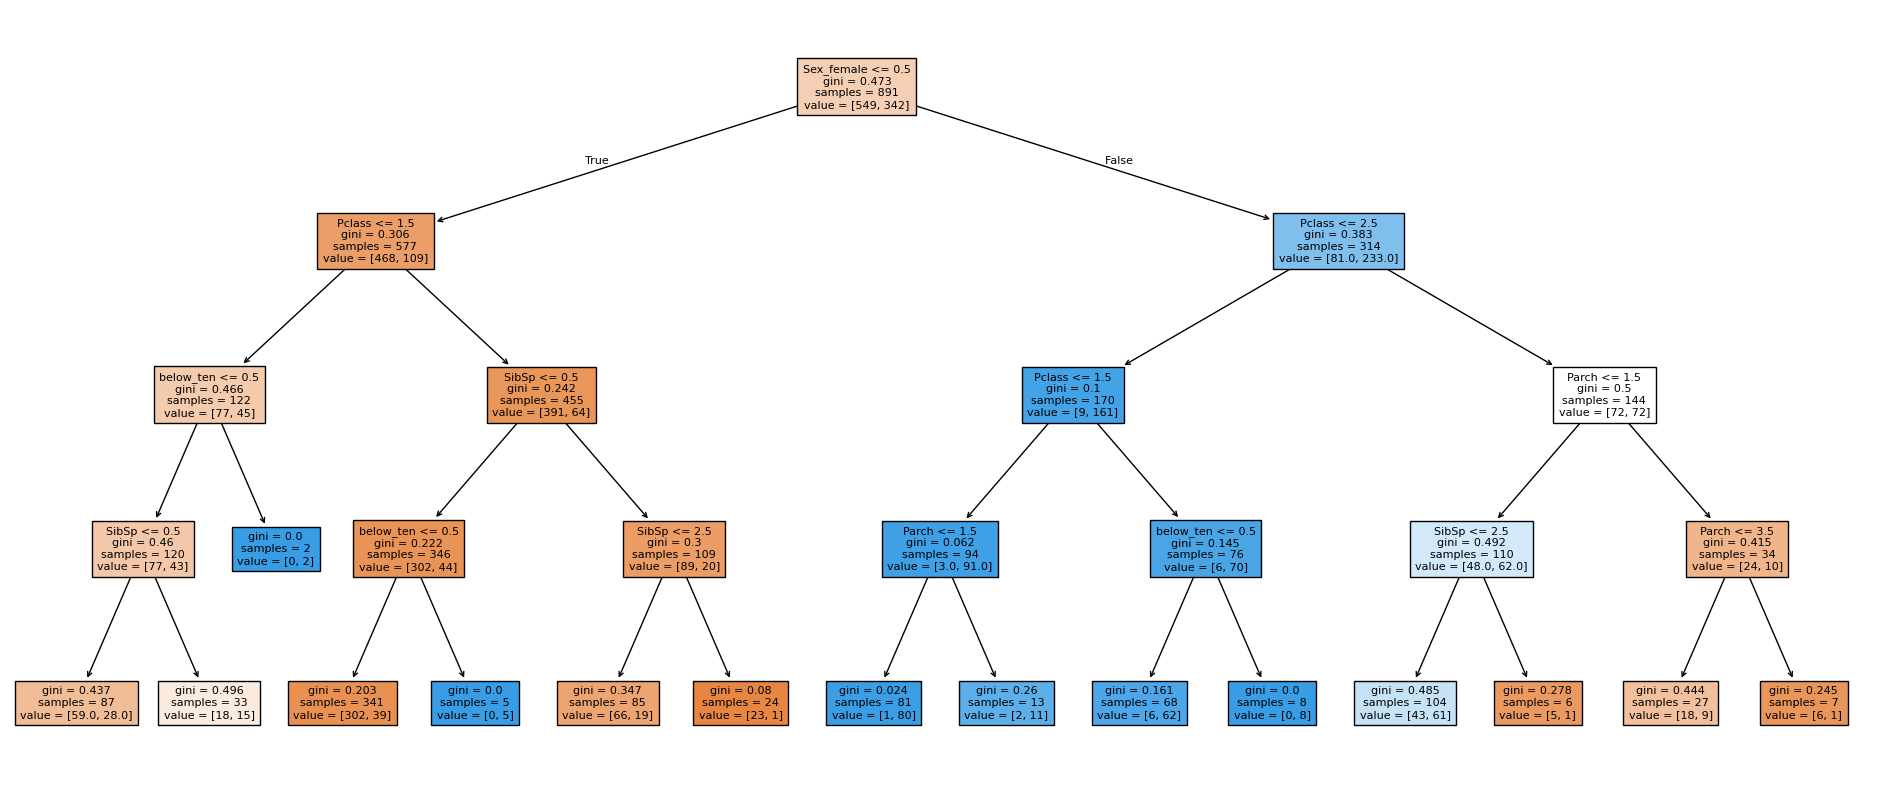

In [23]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize the first few trees from the Random Forest
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
# axes = axes.flatten()

# Plot first 4 trees
# for i in range(min(4, len(model.estimators_))):
#     plot_tree(
#         model.estimators_[i],
#         feature_names=X.columns,
#         filled=True,
#         ax=axes[i],
#         fontsize=8,
#     )
#     axes[i].set_title(f"Tree {i + 1}", fontsize=12)

# plt.tight_layout()
# plt.show()

plt.figure(figsize=(24, 10))
plot_tree(
    model.estimators_[0],
    feature_names=X.columns,
    filled=True,
    fontsize=8,
)
plt.show()

In [ ]:
# Visualize a single tree in more detail (e.g., the first tree)
plt.figure(figsize=(20, 10))
plot_tree(
    model.estimators_[0], feature_names=X.columns, filled=True, fontsize=10, max_depth=4
)
plt.title("Detailed View of Tree 1", fontsize=14)
plt.show()
